In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2 as pg
from questdb.ingress import Sender
from datetime import datetime
from enum import Enum
import time
%matplotlib inline

In [3]:
class SensorName(Enum):

    ACC = 'accelerometeruncalibrated'
    GYRO = 'gyroscopeuncalibrated'

In [4]:
def write_acc(data:dict, db_host:str, db_port:int, table_name:str):

    """
    Write phone accelerometer data to QuestDb 

    Parameters
    ----------
    data : dict
        The raw request data sent by the phone
    db_host : str
        The QuestDb host
    db_port: int
        The QuestDb port
    table_name : str
        The table to write to
    """

    session_id = data['sessionId']
    device_id = data['deviceId']

    for d in data['payload']:

        if d.get("name") == SensorName.ACC.value:

            ts = datetime.fromtimestamp(d["time"] / 1000000000)
            x = d["values"]["x"]
            y = d["values"]["y"]
            z = d["values"]["z"]
            

            with Sender(db_host, db_port) as sender:

                sender.row(
                    table_name,
                    symbols={'device_id':str(device_id),'session_id': str(session_id)},
                    columns={'recorded_timestamp': str(ts) , 'x':x, 'y':y, 'z':z})
                sender.flush()



In [5]:
connection = pg.connect(user="admin",
                            password="quest",
                            host="127.0.0.1",
                            port="8812",
                            database="qdb",
                            options='-c statement_timeout=300000')

In [50]:
cursor = connection.cursor()

#Creating Table Station_Status
cursor.execute("DROP TABLE IF EXISTS acc")
sql = """CREATE TABLE acc (
        device_id TEXT,
        session_id TEXT,
        recorded_timestamp TEXT,
        x REAL,
        y REAL,
        z REAL)"""

cursor.execute(sql)
connection.commit()


In [7]:
data = pd.read_sql("select * from acc", connection)
data.sort_values('recorded_timestamp')

,device_id,session_id,recorded_timestamp,x,y,z
0,86a5b0e3-6e06-40e2-b226-5a72bd39b65b,2680b42b-2dce-47f7-bc20-9e01573ea062,2022-10-15 14:05:09.954855,-0.081,-0.722,-0.697
1,86a5b0e3-6e06-40e2-b226-5a72bd39b65b,2680b42b-2dce-47f7-bc20-9e01573ea062,2022-10-15 14:05:09.974909,-0.094,-0.718,-0.677
2,86a5b0e3-6e06-40e2-b226-5a72bd39b65b,2680b42b-2dce-47f7-bc20-9e01573ea062,2022-10-15 14:05:09.994963,-0.103,-0.706,-0.664
3,86a5b0e3-6e06-40e2-b226-5a72bd39b65b,2680b42b-2dce-47f7-bc20-9e01573ea062,2022-10-15 14:05:10.015016,-0.096,-0.710,-0.670
4,86a5b0e3-6e06-40e2-b226-5a72bd39b65b,2680b42b-2dce-47f7-bc20-9e01573ea062,2022-10-15 14:05:10.035070,-0.079,-0.718,-0.688
...,...,...,...,...,...,...
7731,30d0b4d5-5f4f-4bd3-862f-49e39a81d338,84777ba8-0542-4352-b569-0e9cae3686f5,2022-10-16 16:33:04.569507,-0.077,-0.003,-0.715
7732,30d0b4d5-5f4f-4bd3-862f-49e39a81d338,84777ba8-0542-4352-b569-0e9cae3686f5,2022-10-16 16:33:04.589586,-0.044,-0.021,-0.685
7733,30d0b4d5-5f4f-4bd3-862f-49e39a81d338,84777ba8-0542-4352-b569-0e9cae3686f5,2022-10-16 16:33:04.609698,-0.079,0.155,-1.490
7734,30d0b4d5-5f4f-4bd3-862f-49e39a81d338,84777ba8-0542-4352-b569-0e9cae3686f5,2022-10-16 16:33:04.629779,-0.069,0.135,-0.926


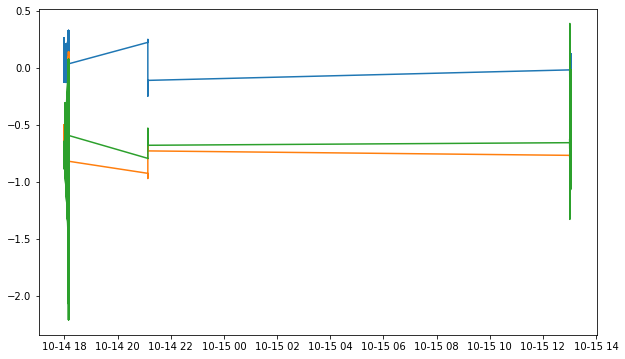

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))
for axis in ['x','y','z']:

    ax.plot(pd.to_datetime(data['recorded_timestamp']), data[axis])

In [43]:
connection.cursor().execute('''drop table acc''')

In [44]:
connection.close()

In [53]:
while True:
    
    data = pd.read_sql("select * from acc order by recorded_timestamp desc limit 10", connection)
    print(data['recorded_timestamp'].max())
    time.sleep(1)

2022-10-15 14:11:32.065575
2022-10-15 14:11:32.065575
2022-10-15 14:11:32.065575
2022-10-15 14:11:32.065575
2022-10-15 14:11:48.808460
2022-10-15 14:11:49.550468
2022-10-15 14:11:50.673509
2022-10-15 14:11:51.816609
2022-10-15 14:11:52.839375
2022-10-15 14:11:53.862153
2022-10-15 14:11:54.904981
2022-10-15 14:11:55.747261
2022-10-15 14:11:56.569492
2022-10-15 14:11:56.569492
2022-10-15 14:11:56.569492
2022-10-15 14:11:56.569492
2022-10-15 14:11:56.569492
2022-10-15 14:12:02.084527
2022-10-15 14:12:03.107308
2022-10-15 14:12:04.150138
2022-10-15 14:12:04.852046
2022-10-15 14:12:05.574008
2022-10-15 14:12:05.574008
2022-10-15 14:12:05.574008
2022-10-15 14:12:05.574008
2022-10-15 14:12:05.574008
2022-10-15 14:12:05.574008
2022-10-15 14:12:05.574008
2022-10-15 14:12:05.574008
2022-10-15 14:12:05.574008


KeyboardInterrupt: 